In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

In [47]:
fc = FileChooser('/sf/alvra/data/p18938/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18938/raw/scan_info', filename='', show_hidden='False')

In [74]:
quantile_band = 0.2

channel_list = [channel_PIPS_trans, channel_Izero117, channel_Izero122]#, channel_PSSS_y, channel_PSSS_x]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

PIPS = []
Izero117 = []
Izero122 = []
NormPSSS = []
Spectrum_PSSS = []
PSSS_eV =[]

Signal = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    try:
    
        results, _ = load_data_compact(channel_list, step)

        PIPS_shot = results[channel_PIPS_trans]
        Izero117_shot = results[channel_Izero117]
        Izero122_shot = results[channel_Izero122]
  #      PSSS_shot = results[channel_PSSS_y]#.mean(axis = 0)
  #      PSSS_eV = results[channel_PSSS_x].mean(axis = 0)

        df_PIPS = pd.DataFrame(PIPS_shot)
        PIPS.append(np.quantile(df_PIPS, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        df_Izero117 = pd.DataFrame(Izero117_shot)
        Izero117.append(np.quantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        df_Izero122 = pd.DataFrame(Izero122_shot)
        Izero122.append(np.quantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        PSSS_integral = np.mean(PSSS_shot, axis = 1)
 #       df_NormPSSS = pd.DataFrame(PSSS_integral)
 #       NormPSSS.append(np.quantile(df_NormPSSS, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        df_signal_norm = pd.DataFrame(Izero117_shot)# / PSSS_integral)
        Signal.append(np.quantile(df_signal_norm, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

        Spectrum_PSSS.append(PSSS_shot.mean(axis = 0))
    except:
        Energy_eV = np.delete(Energy_eV, i)

Energy_eV = Energy_eV[:np.shape(Signal)[0]]
    
Spectrum_PSSS = np.asarray(np.mean(Spectrum_PSSS, axis = 0))
PSSS_eV = np.asarray(PSSS_eV)
NormPSSS = np.asarray(NormPSSS)
Izero117 = np.asarray(Izero117)
Izero122 = np.asarray(Izero122)
PIPS = np.asarray(PIPS)

Signal = np.asarray(Signal)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))


Step 26 of 26: Processing run_034864

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 248 / 250 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 248 / 250 -> 1% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.4,0.6


In [75]:
# Normalization with the PSSS integral

Signal_norm = Signal #Izero117 / NormP|SS

# No normalization 

#Signal_norm = Izero117

<IPython.core.display.Javascript object>


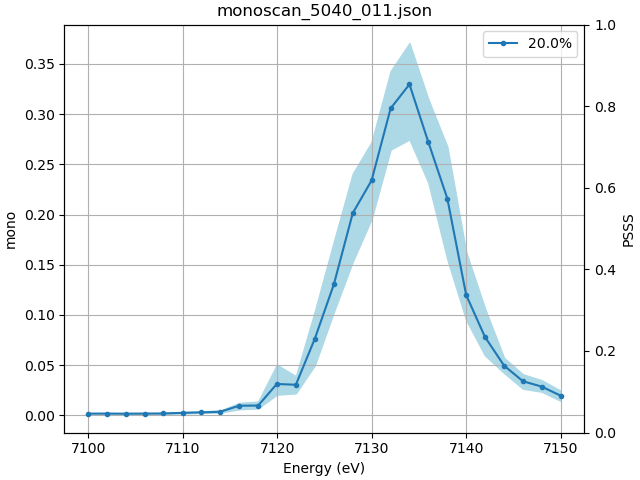

In [76]:
Int = Signal_norm[:,0]
err_low = Signal_norm[:,1]
err_high = Signal_norm[:,2]

fig, ax1 = plt.subplots(constrained_layout=True)
ax2 = ax1.twinx()
plt.title(fc.selected_filename)

#ax2.plot(PSSS_eV, Spectrum_PSSS, label='PSSS avg spectrum', color = 'coral')
ax1.plot(Energy_eV, Int, label='{}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Energy_eV, err_low, err_high, color='lightblue')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("mono")
ax2.set_ylabel("PSSS")
ax1.legend(loc="best")
ax1.grid()

plt.show()

In [77]:
spectrum_toFit = np.copy(Signal_norm[:,0])
Energy_eV_toFit = np.copy(Energy_eV.ravel())

def gaussian(x, amp, cen, wid, c):
    return amp * np.exp(-4*(np.log(2))*(x-cen)**2 / wid**2)+c

# Now fit with error funciton
index = ~(np.isnan(Energy_eV_toFit) | np.isnan(spectrum_toFit))

parameters,extras = curve_fit(gaussian, Energy_eV_toFit[index], spectrum_toFit[index], p0 = [0.3, 7125, 7,0.01])
#parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit, Pump_probe_toFit, p0 = [0.01, 0.12, 161, 0.1])

print("Position t0 =",np.round(parameters[1],3),"eV")
print("Width =",np.abs(np.round(parameters[2],3)),"eV")
print("Bandwidth = {} %".format(np.abs(np.round(parameters[2],3))/np.round(parameters[1],3)*100))

#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)

Position t0 = 7133.213 eV
Width = 12.277 eV
Bandwidth = 0.17211037999285875 %


<IPython.core.display.Javascript object>


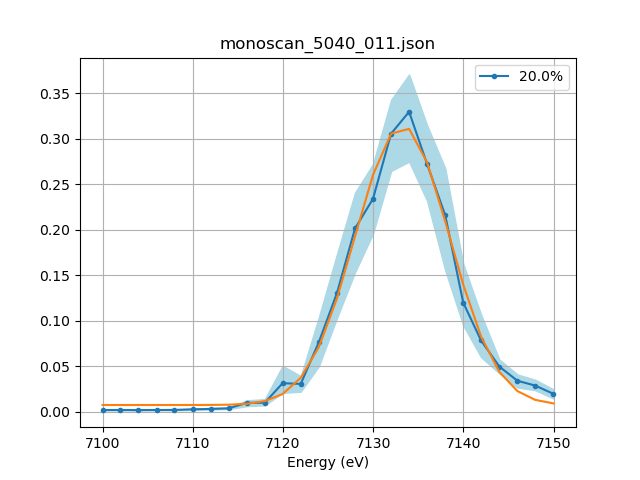

In [78]:
plt.figure()

plt.plot(Energy_eV, Int, label='{}%'.format(quantile_band*100),marker='.')
plt.fill_between(Energy_eV, err_low, err_high, color='lightblue')

plt.plot(Energy_eV_toFit, gaussian(Energy_eV_toFit,*parameters))

plt.title(fc.selected_filename)
plt.grid()
plt.xlabel("Energy (eV)")
plt.legend(loc="best")


plt.show()

In [40]:
Signal_norm1 = Signal_norm.copy()

<IPython.core.display.Javascript object>


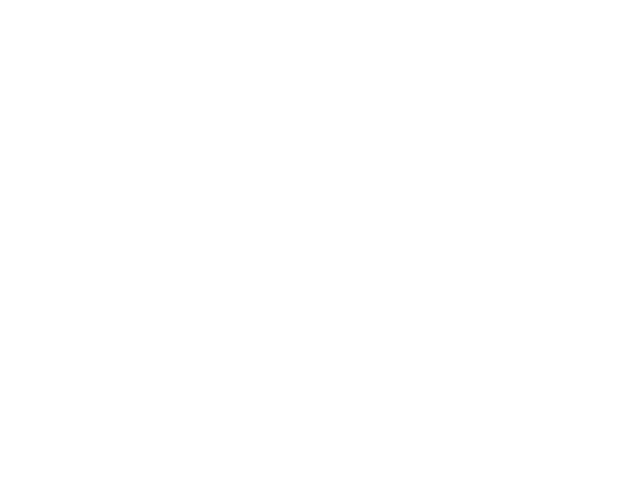

NameError: name 'Signal_norm_1' is not defined

In [41]:
plt.figure()

plt.plot(Energy_eV, Signal_norm_1, label="original",marker='.')
plt.plot(Energy_eV, Signal_norm_3, label="first try",marker='.')
plt.plot(Energy_eV, Signal_norm_2, label="second try",marker='.')

low_err= Signal_norm - err_Signal_norm
high_err= Signal_norm + err_Signal_norm


#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Energy (eV)")
plt.legend(loc="best")


plt.show()
#plt.savefig('Timescan_7_diode')